In [1]:
from selenium import webdriver as wd
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import time
import pandas as pd
import re
from selenium.webdriver.common.keys import Keys
import datetime as dt
import os
import matplotlib.pyplot as plt

In [2]:
def cleanText(readData):
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    return text

# 플레이리스트 목록, 링크 추출

In [3]:
def get_plyst_url():
    search = input()
    url='https://www.youtube.com/results?search_query='+parse.quote(search)+'&sp=EgIQAg%253D%253D'
    result = urlopen(url)
    html = result.read()
    soup = BeautifulSoup(html, 'html.parser')
    k=soup.find('a',{'class':"yt-uix-tile-link yt-ui-ellipsis yt-ui-ellipsis-2 yt-uix-sessionlink spf-link"})
    channel='https://www.youtube.com'+k['href']
    playlist=channel+'/playlists?view=1&flow=grid'
    driver = wd.Chrome(executable_path="chromedriver.exe")
    driver.get(playlist)
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_page_height == last_page_height:
            break
        last_page_height = new_page_height
    html2=driver.page_source
    driver.close()
    soup = BeautifulSoup(html2, 'html.parser')
    a=soup.find_all('a',{'class':"yt-simple-endpoint style-scope ytd-grid-playlist-renderer"})
    playlist_link={}
    for i in range(len(a)):
        playlist_link[a[i]['title']]='https://www.youtube.com'+a[i]['href']
    return playlist_link

# 플레이리스트별 영상 링크 추출(플레이리스트 당 최대 200개) 

In [4]:
def get_video_from_plyst(a):
    url = a
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    url=soup.find_all('a',{'class':'spf-link playlist-video clearfix yt-uix-sessionlink spf-link'})
    title = soup.find_all('h4',{'class':"yt-ui-ellipsis yt-ui-ellipsis-2"})
    video={'title':[],'link':[]}
    for i in range(len(url)):
        video['title'].append(title[i].text.strip())
        video['link'].append('https://www.youtube.com'+url[i]['href'])    
    return video

# 댓글 크롤링

In [136]:
def get_comment(url):
    comment_data = pd.DataFrame({'youtube_id':[],
                                'comment':[],
                                'like_num':[]})
    delay=3

    driver = wd.Chrome(executable_path="chromedriver.exe")#chrome_options=options
    driver.implicitly_wait(delay)

    start_url = url
    driver.get(start_url) 
    
    time.sleep(3)
    body = driver.find_element_by_tag_name('body')
    
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    
    num_page_down = 1
    while num_page_down:
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(1.5)
        num_page_down -= 1
    
    time.sleep(3.0)

    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_page_height == last_page_height:
            break
        last_page_height = new_page_height

    html = driver.page_source
    driver.close()
    html_s = BeautifulSoup(html,'html.parser')

    comment0 = html_s.find_all('ytd-comment-renderer',
                               {'class':'style-scope ytd-comment-thread-renderer'})

    for i in range(len(comment0)):
        #댓글
        comment = comment0[i].find('yt-formatted-string',
                                   {'id':'content-text','class':'style-scope ytd-comment-renderer'}).text
    
        try:
            aa = comment0[i].find('span',{'id':'vote-count-left'}).text
            #정규표현식으로 숫자만 추출하는 것은 정규표현식에 대한 공부를 더 한 뒤 해결
            #re.findall('[0-9]',aa)
            #"".join(re.findall('[0-9]',aa)) -> 리스트 내부의 문자열의 합
            like_num = "".join(re.findall('[0-9]',aa)) + "개"
        except:
            like_num = 0
        
        bb = comment0[i].find('a',{'id':'author-text'}).find('span').text
        youtube_id = "".join(re.findall('[가-힣0-9a-zA-Z]',bb))
    
        insert_data =  pd.DataFrame({'youtube_id':[youtube_id],
                                                   'comment':[comment],
                                                   'like_num':[like_num]})

        comment_data = comment_data.append(insert_data)
    
    comment_data.index = range(len(comment_data))
    return comment_data

# 플레이리스트 이름으로 폴더 생성

In [6]:
a = get_plyst_url()
videos={}

for i in a.keys():
    videos[i] = get_video_from_plyst(a[i])
for i in videos.keys():
    try:
        if not(os.path.isdir(cleanText(i))):
            os.makedirs(os.path.join(cleanText(i)))
    except OSError as e:
        if e.errno != errno.EEXIST:
            print("Failed to create directory!!!!!")
            raise

오프로


# 동영상별 댓글을 크롤링하여 플레이리스트 폴더에 저장

In [138]:
for i in videos.keys():
    for j in range(len(videos[i]['link'])):
        print('Now Crawling: link[{}]'.format(j))
        comment=get_comment(videos[i]['link'][j])
        if len(comment)==0:
            continue
        comment.to_excel('C:\jupyter\\'+cleanText(i)+'\\{}_'.format(j)+cleanText(videos[i]['title'][j])+'.xlsx')

Now Crawling: link[0]
Now Crawling: link[1]
Now Crawling: link[2]
Now Crawling: link[3]
Now Crawling: link[4]
Now Crawling: link[5]
Now Crawling: link[6]
Now Crawling: link[7]
Now Crawling: link[8]
Now Crawling: link[9]
Now Crawling: link[10]
Now Crawling: link[11]
Now Crawling: link[12]
Now Crawling: link[13]
Now Crawling: link[14]
Now Crawling: link[15]
Now Crawling: link[16]
Now Crawling: link[17]
Now Crawling: link[18]
Now Crawling: link[19]
Now Crawling: link[20]
Now Crawling: link[21]
Now Crawling: link[22]
Now Crawling: link[23]
Now Crawling: link[24]
Now Crawling: link[25]
Now Crawling: link[26]
Now Crawling: link[27]
Now Crawling: link[28]
Now Crawling: link[29]
Now Crawling: link[30]
Now Crawling: link[31]
Now Crawling: link[32]
Now Crawling: link[33]
Now Crawling: link[34]
Now Crawling: link[35]
Now Crawling: link[36]
Now Crawling: link[37]
Now Crawling: link[38]
Now Crawling: link[39]
Now Crawling: link[40]
Now Crawling: link[41]
Now Crawling: link[42]
Now Crawling: link[43

# 플레이리스트의 영상 정보 추출

In [114]:
#입력 파라미터로 plyst_video에는 videos['key'] 넣으시면 됩니다.
def info_from_video(plyst_video):
    title = plyst_video['title']
    link = plyst_video['link']
    thumnail = []
    like = []
    dislike = []
    view = []
    upload_date=[]
    num = len(link)
    while num:
        i = len(link)-num
        print('Now Crawling: link[{}]'.format(i))
        url = link[i]
        html = urlopen(url)
        time.sleep(0.5)
        soup = BeautifulSoup(html, 'html.parser')
        thumnail.append(soup.find('meta',{'name':"twitter:image"})['content'])
        temp = soup.find('button',{'title':'이 동영상이 마음에 듭니다.'})
        try:
            temp = temp.text
        except:
            thumnail = thumnail[:(len(thumnail)-1)]
            continue
        like.append(temp)
        temp = soup.find('button',{'title':'이 동영상이 마음에 들지 않습니다.'})
        temp = temp.text
        dislike.append(temp)
        view.append(soup.find('div',{'class':"watch-view-count"}).text.strip())
        upload_date.append(soup.find('strong',{'class':'watch-time-text'}).text)
        num-=1

    info = {'title':title,'link':link,'thumnails':thumnail,'upload date':upload_date,'like':like,'dislike':dislike,'view':view}
    info_df = pd.DataFrame(info)
    return info_df

In [115]:
for i in videos.keys():
    info=info_from_video(videos[i])
    info.to_excel('C:\jupyter\\'+cleanText(i)+'\\'+cleanText(i)+'_info'+'.xlsx')

Now Crawling: link[0]
Now Crawling: link[1]
Now Crawling: link[2]
Now Crawling: link[3]
Now Crawling: link[4]
Now Crawling: link[5]
Now Crawling: link[6]
Now Crawling: link[7]
Now Crawling: link[8]
Now Crawling: link[9]
Now Crawling: link[9]
Now Crawling: link[10]
Now Crawling: link[11]
Now Crawling: link[12]
Now Crawling: link[13]
Now Crawling: link[14]
Now Crawling: link[15]
Now Crawling: link[16]
Now Crawling: link[17]
Now Crawling: link[18]
Now Crawling: link[19]
Now Crawling: link[20]
Now Crawling: link[20]
Now Crawling: link[21]
Now Crawling: link[22]
Now Crawling: link[23]
Now Crawling: link[24]
Now Crawling: link[25]
Now Crawling: link[26]
Now Crawling: link[27]
Now Crawling: link[28]
Now Crawling: link[29]
Now Crawling: link[30]
Now Crawling: link[31]
Now Crawling: link[32]
Now Crawling: link[33]
Now Crawling: link[34]
Now Crawling: link[35]
Now Crawling: link[36]
Now Crawling: link[37]
Now Crawling: link[38]
Now Crawling: link[39]
Now Crawling: link[40]
Now Crawling: link[41]

# 메타데이터 크롤링 코드

In [39]:
def uniq(input):
    output = []
    for x in input:
        if x not in output:
            output.append(x)
    return output

# 키워드 기반 링크 추출

In [41]:
def _searchkeyword(keyword):
    url = 'https://www.youtube.com/results?search_query=' + keyword +'+-2020' +'&sp=EgIQAQ%253D%253D'
    driver = wd.Chrome(executable_path="chromedriver.exe")
    driver.get(url)

    time.sleep(5)
    endk = 3

    meta = {'title':[],'link':[]}

    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        html2=driver.page_source
        soup = BeautifulSoup(html2, 'lxml')
        a=soup.find_all('a',{'id':"video-title"})
        for i in a:
            meta['link'].append('https://www.youtube.com'+i['href'])
            meta['title'].append(i['title'])
        meta['link']=uniq(meta['link'])
        meta['title']=uniq(meta['title'])
        if len(meta['link']) > 100:
            break
        
    driver.close()
    return meta

# 링크에서 정보 추출

In [24]:
def _info_from_meta(plyst_video):
    title = plyst_video['title']
    link = plyst_video['link']
    thumnail = []
    like = []
    dislike = []
    view = []
    upload_date=[]
    num = len(link)
    link2 = []
    title2 = []
    thum_err=[]
    like_err=[]
    subscribe=[]
    cnt=0
    while num:
        i = len(link)-num
        print('Now Crawling: link[{}]'.format(i))
        url = link[i]
        name = title[i]
        html = urlopen(url)
        time.sleep(0.5)
        soup = BeautifulSoup(html, 'html.parser')
        try:
            thumnail.append(soup.find('meta',{'name':"twitter:image"})['content'])
        except:
            print('Error: Thumnail Error')
            num-=1
            thum_err.append(i)
            continue
            
        temp = soup.find('button',{'title':'이 동영상이 마음에 듭니다.'})
        try:
            temp = temp.text
        except:
            thumnail = thumnail[:(len(thumnail)-1)]
            cnt+=1
            if cnt == 4:
                cnt=0
                num-=1
            continue
        like.append(temp)
        temp = soup.find('button',{'title':'이 동영상이 마음에 들지 않습니다.'})
        temp = temp.text
        dislike.append(temp)
        view.append(soup.find('div',{'class':"watch-view-count"}).text.strip())
        upload_date.append(soup.find('strong',{'class':'watch-time-text'}).text)
        link2.append(url)
        title2.append(name)
        try:
            subscribe.append(soup.find('span',{'tabindex':'0'}).text.strip())
        except:
            subscribe.append('X')
        num-=1

    info = {'title':title2,'link':link2,'thumnails':thumnail,'upload date':upload_date,'like':like,'dislike':dislike,'view':view
           ,'subscribe':subscribe}
    info_df = pd.DataFrame(info)
    
    #여기서부터 전처리 코드
    for idx, info_df['subscribe']_df['subscribe']):
        if i[-1] == '만':
            info_df['subscribe'][idx] = float(i[:-1])*10000
        elif i == 'X':
            info_df['subscribe'][idx] = -1
        elif i[-1] == '천':
            info_df['subscribe'][idx] = float(i[:-1])*1000
        else:
            i = float(i)
            
    info_df['upload date'] = ['-'.join(re.findall('\d+',re.sub('[ㄱ-힣\: ]','',j))) for j in info_df['upload date']]
    info_df['like'] = [int(re.sub(',','',i)) for i in info_df['like']]
    info_df['dislike'] = [int(re.sub(',','',i)) for i in info_df['dislike']]
    info_df['view'] = [int(re.sub('[ㄱ-힣\,]','',i)) for i in info_df['view']]
    
    info_df = info_df[info_df['subscribe']!=-1][info_df['like']!='' ]
    
    info_df['like_ratio'] = round(info_df['like'] / (info_df['like'] + info_df['dislike']),5)
    info_df['view_subscribe'] = round(info_df['view']/ info_df['subscribe'],5)
    info_df['like_subscribe'] = round(info_df['like']/ info_df['subscribe'],5)
    info_df['like_view'] = round(info_df['like']/ info_df['view'],5)
    
    return info_df

# 크롤링 자동화 함수

In [2]:
#메타데이터 크롤링
def crawling_meta_data():
    keyword=[]
    print('If you want to enter keywords, please enter \'n\'')
    while 1:
        k=input('Please Enter the contents Keyword: ')
        if k == 'n':
            break
        else: keyword.append(k)
    
    #메타데이터를 저장할 디렉토리 생성
    try:
        if not(os.path.isdir('meta_data')):
            os.makedirs(os.path.join('meta_data'))
    except OSError as e:
        if e.errno != errno.EEXIST:
            print("Failed to create directory!!!!!")
            raise
    
    df={}
    meta={}
        
    for i in keyword:
        meta[i] = _searchkeyword(i)
        df[i]=_info_from_meta(meta[i])
        df[i].to_csv('.\\meta_data\\{}.txt'.format(i))
    
    return df

## 필요 데이터
### 1. nadrop.txt 파일
### 2. 오프로 카테고리별 폴더파일

In [1]:
from selenium import webdriver as wd
from selenium.webdriver.common.keys import Keys
from time import localtime, strftime
from urllib.request import urlopen
from urllib import parse
import time
from bs4 import BeautifulSoup
import pandas as pd
import csv
import re
import pandas as pd
import re

In [2]:
keyword = ['식당후기','직업','브이로그','토크','제품리뷰']
categories =  ['♣Food  Restaurant Review', '♣JOB소리 Talk', '♣Vlog l여행', 
               '♣오프로 Talk', '♣제품 리뷰 l Product Review']

In [3]:
meta_data={}
#수정된 코드는 .txt로 바로 불러와도 되지만 저희는 _meta_2.txt로 불러와야합니다.
for i in keyword:
    meta_data[i] = pd.read_csv(i+'nadrop.txt').dropna(axis=0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.stats import poisson as poi
import os

In [5]:
import math as m

In [6]:
import re
import matplotlib.font_manager as fm

In [10]:
for i in keyword:
    meta_data[i] = meta_data[i][meta_data[i]['subscribe']!=-1][meta_data[i]['like']!=999999 ]
    meta_data[i] = meta_data[i][meta_data[i]['subscribe'] > 0]
    meta_data[i] = meta_data[i][meta_data[i]['like'] > 1]

In [13]:
def getresults(key):
    fontprop = fm.FontProperties(fname="NanumGothicBold.ttf", size=24)
    
    path = "오프로//"+categories[key]
    file_list = os.listdir(path)
    file_path = path + "//"+file_list[-1]
    org_df = pd.read_excel(file_path)
    org_df['subscribe'] = float(19200)
    
    # 데이터 전처리
    org_df['upload date'] = ['-'.join(re.findall('\d+',re.sub('[ㄱ-힣\: ]','',j))) for j in org_df['upload date']]
    org_df['like'] = [float(re.sub(',','',str(i))) for i in org_df['like']]
    org_df['dislike'] = [float(re.sub(',','',str(i))) for i in org_df['dislike']]
    org_df['view'] = [int(re.sub('[ㄱ-힣\,]','',i)) for i in org_df['view']]
    
    # 지표 생성
    org_df = org_df[['title','upload date', 'like', 'dislike','view','subscribe' ]]
    org_df['like_ratio'] = round(org_df['like'] / (org_df['like'] + org_df['dislike']),5)
    org_df['view_subscribe'] = round(org_df['view']/ org_df['subscribe'],5)
    org_df['like_subscribe'] = round(org_df['like']/ org_df['subscribe'],5)
    org_df['like_view'] = round(org_df['like']/ org_df['view'],5)
    
    #결측치 제거
    org_df=org_df.dropna(axis=0)

    # 지표별 평균 구하기
    like_ratio = org_df['like_ratio'].mean()
    view_subscribe = org_df['view_subscribe'].mean()
    like_view = org_df['like_view'].mean()
    like_subscribe = org_df['like_subscribe'].mean()
    i = keyword[key]
    
    f = plt.figure(figsize=(10,10))
    fig1 = f.add_subplot(221)
    fig2 = f.add_subplot(222)
    fig3 = f.add_subplot(223)
    fig4 = f.add_subplot(224)

    
    print(i,"장르 내 결과입니다.")
    # like_view
    
    lamb1=sum(meta_data[i]['like_view'])*1000/len(meta_data[i]['like_view'])
    max1 = max(meta_data[i]['like_view']*1000)
    min1 = min(meta_data[i]['like_view']*1000)
    x1=np.linspace(min1,max1,100)
    y1=poi(lamb1).pmf(x1)
        
    fig1.set_title('1000조회수 당 좋아요',fontproperties=fontprop,fontsize=10)
    fig1.set_ylabel('확률',fontproperties=fontprop,fontsize=10)
    fig1.plot(x1,y1)
        
    mu=np.arange(0,round((like_view*1000),0)+1,1)
    mu_y=poi(lamb1).pmf(mu)
    tier = round((1-sum(mu_y))*100,2)
    
    fig1.plot(mu,mu_y,'r')
    fig1.fill_between(mu,mu_y,facecolor='r')
    
    fig1.set_xlabel('조회수 대비 좋아요 비율은 상위 {}%입니다'.format(tier),fontproperties=fontprop,fontsize=12)

    
    
    # like_subscribe
    logged = np.log(meta_data[i][meta_data[i]['like_subscribe']<200]['like_subscribe'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    rv = st.norm(loc = m, scale = std)
    max2=max(logged)
    min2=min(logged)
    x2=np.linspace(min2,max2,100)
    y2=rv.pdf(x2)
    fig2.plot(x2,y2)
    mu2=np.linspace(min2,np.log(like_subscribe),100)
    mu2_y=rv.pdf(mu2)
    fig2.plot(mu2,mu2_y,'r')
    fig2.fill_between(mu2,mu2_y,facecolor='r')
    tik=np.linspace(min2,max2,5)
    fig2.set_xticks(tik)
    fig2.set_xticklabels([round(i,2)for i in np.exp(tik)]) 
    
    tier = round(100-rv.cdf(np.log(like_subscribe))*100,2)
    fig2.set_xlabel('구독자 대비 좋아요 상위 {}%입니다'.format(tier),fontproperties=fontprop,fontsize=12)
    fig2.set_ylabel('확률',fontproperties=fontprop,fontsize=10)
    fig2.set_title('좋아요/구독자',fontproperties=fontprop,fontsize=10)
    
    
    # like_ratio
    logged = np.log(meta_data[i]['like_ratio'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    a, loc, scale = st.skewnorm.fit(logged)
    rv = st.skewnorm(a = a, loc = loc, scale = scale)
    max3=max(logged)
    min3=min(logged)
    x3=np.linspace(min3,max3,100)
    y3=rv.pdf(x3)
    fig3.plot(x3,y3)
    mu3=np.linspace(min3,np.log(like_ratio),100)
    mu3_y=rv.pdf(mu3)
    fig3.plot(mu3,mu3_y,'r')
    fig3.fill_between(mu3,mu3_y,facecolor='r')
    tier = round(100-rv.cdf(np.log(like_ratio))*100,2)
    tik=np.linspace(min3,max3,5)
    fig3.set_xticks(tik)
    fig3.set_xticklabels([round(i,2)for i in np.exp(tik)])
    fig3.set_xlabel('좋아요 비율은 상위 {}%입니다'.format(tier),fontproperties=fontprop,fontsize=12)
    fig3.set_ylabel('확률',fontproperties=fontprop,fontsize=10)
    fig3.set_title('좋아요/좋아요+싫어요',fontproperties=fontprop,fontsize=10)
    
    # view_subscribe
    logged = np.log(meta_data[i]['view_subscribe'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    rv = st.norm(loc = m, scale = std)
    max4=max(logged)
    min4=min(logged)
    x4=np.linspace(min4,max4,100)
    y4=rv.pdf(x4)
    fig4.plot(x4,y4)
    mu4=np.linspace(min4,np.log(view_subscribe),100)
    mu4_y=rv.pdf(mu4)
    fig4.plot(mu4,mu4_y,'r')
    fig4.fill_between(mu4,mu4_y,facecolor='r')
    tier = round(100-rv.cdf(np.log(view_subscribe))*100,2)
    tik=np.linspace(min4,max4,5)
    fig4.set_xticks(tik)
    fig4.set_xticklabels([round(i,2)for i in np.exp(tik)])
    fig4.set_xlabel('구독자 대비 조회수 비율은 상위 {}%입니다'.format(tier),fontproperties=fontprop,fontsize=12)
    fig4.set_ylabel('확률',fontproperties=fontprop,fontsize=10)
    fig4.set_title('조회수/구독자',fontproperties=fontprop,fontsize=10)
    plt.show()
    f.savefig(i+'.png',dpi=f.dpi)

식당후기 장르 내 결과입니다.


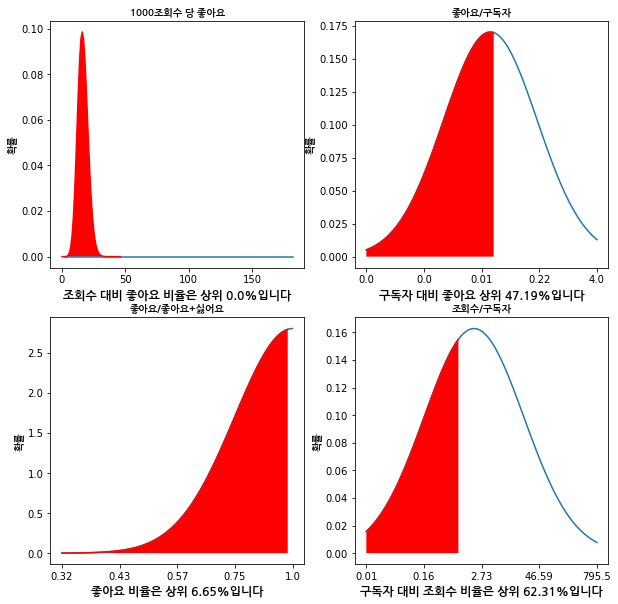



직업 장르 내 결과입니다.


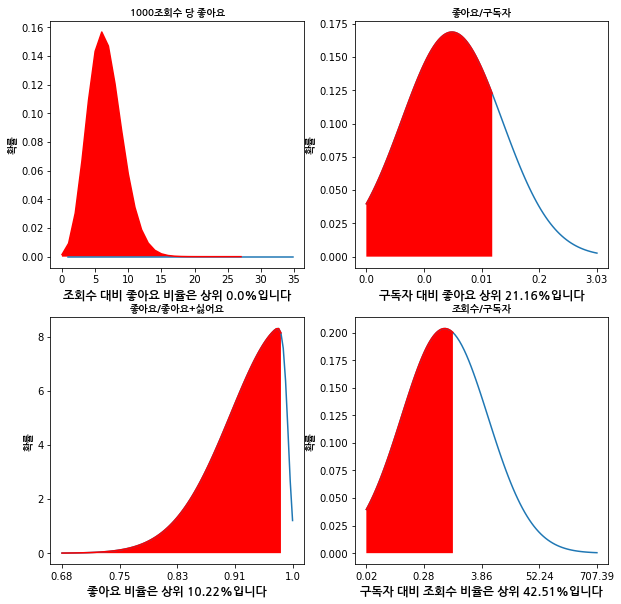



브이로그 장르 내 결과입니다.


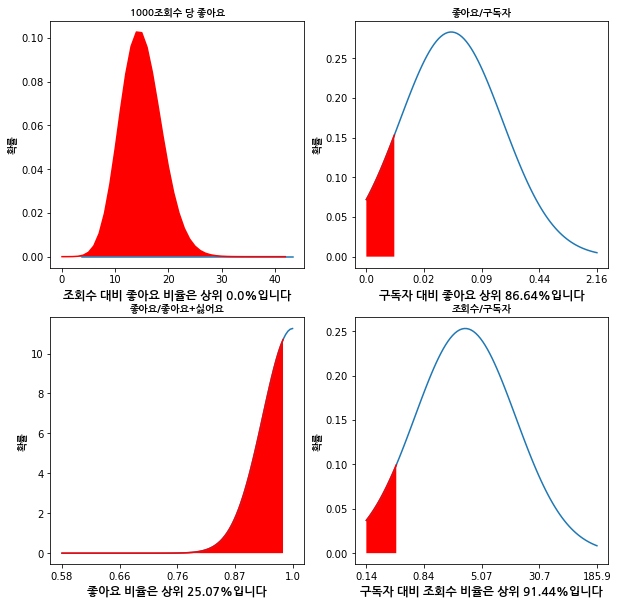



토크 장르 내 결과입니다.


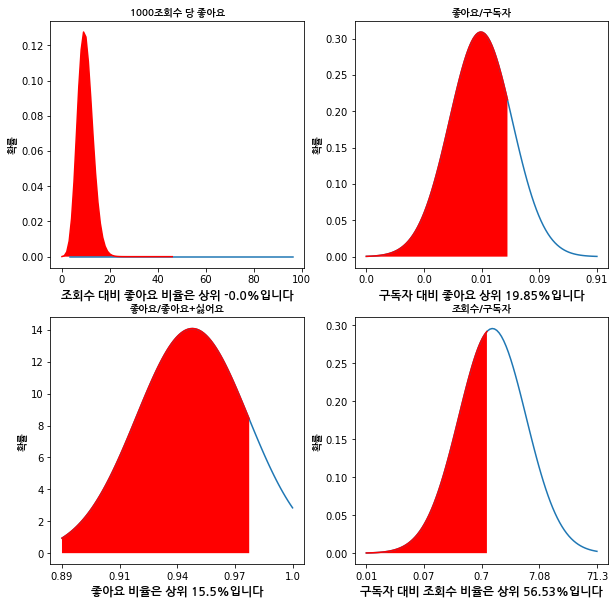



제품리뷰 장르 내 결과입니다.


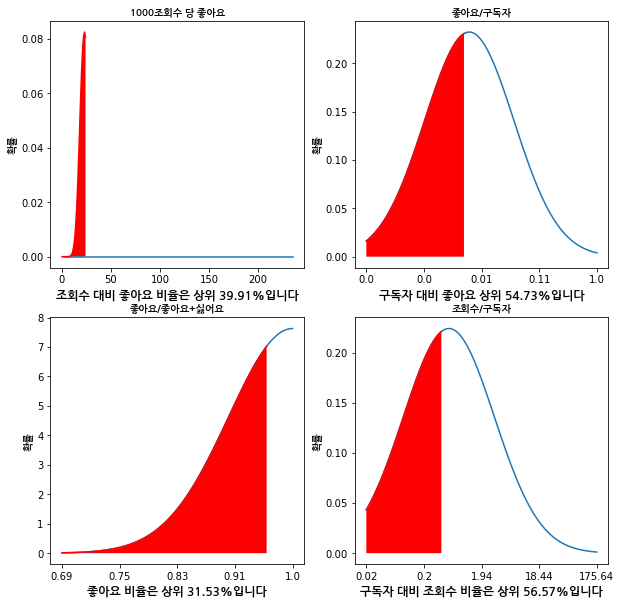

In [14]:
for i in range(len(keyword)):
    getresults(i)
    print('\n')

# Sentiment 적용

## Vlog

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,24):
    dfname = "Vlog" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)

In [5]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,(★여러분 영상 중에 제가 근대를 샐러드에 포함해서 먹는 장면이 나오는데 근대는 생...,10개
1,1,재횬,고민을 들어주세요\n안녕하세요\n전 학생입니다\n전 학원에서 제 잘못땜에 사이가 틀...,3개
2,2,GraceJeon,바른생활오프로님!\n오프로님의 잡소리에 공감 많이 하다가 구독자가 되었는데...\n...,2개
3,3,보나,박스안 구독종이 정말 혼자 빵터져 웃었네요 🤭🤭🤭🤭\n일상 브이로그 영상 넘 좋아요🤗🤭👍,3개
4,4,MmM,와...자취하면서 뭔가를 해먹는다는게 대단👍,3개


In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='갈등'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

k_t=pd.DataFrame(k)

pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

k_f=k_t.T

k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])df.reset_index(drop=True, inplace=True) #데이터프레임 리인덱싱

In [14]:
#텍스트 전처리
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

,W1,W1W2P,W1W2N,neg_cnt,pos_cnt,N,MI_N,MI_P,SO_MI
다낭,4698,2592,162,27540,121986,3644676,31.688619,37.835734,6.147115
본,2916,2430,162,27540,121986,3644676,32.376675,38.430681,6.054006
재밌게,2754,2106,162,27540,121986,3644676,32.459137,38.306692,5.847555
연말,1944,1620,162,27540,121986,3644676,32.961638,38.430681,5.469043
이에요,2430,1620,162,27540,121986,3644676,32.639709,38.108753,5.469043
...,...,...,...,...,...,...,...,...,...
직장,648,162,324,27540,121986,3644676,35.546600,36.693715,1.147115
이상하게,486,162,486,27540,121986,3644676,36.546600,37.108753,0.562153
후회,486,162,486,27540,121986,3644676,36.546600,37.108753,0.562153
파,648,162,486,27540,121986,3644676,36.131563,36.693715,0.562153


In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_vlog.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_vlog.xlsx')

In [38]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio
0,0,0,오프로OhPro,(★여러분 영상 중에 제가 근대를 샐러드에 포함해서 먹는 장면이 나오는데 근대는 생...,10,33,0.36
1,1,1,재횬,고민을 들어주세요\n안녕하세요\n전 학생입니다\n전 학원에서 제 잘못땜에 사이가 틀...,3,43,0.33
2,2,2,GraceJeon,바른생활오프로님!\n오프로님의 잡소리에 공감 많이 하다가 구독자가 되었는데...\n...,2,40,0.60
3,3,3,보나,박스안 구독종이 정말 혼자 빵터져 웃었네요 🤭🤭🤭🤭\n일상 브이로그 영상 넘 좋아요🤗🤭👍,3,8,0.57
4,4,4,MmM,와...자취하면서 뭔가를 해먹는다는게 대단👍,3,4,0.50


In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio,like_score
0,0,0,오프로OhPro,(★여러분 영상 중에 제가 근대를 샐러드에 포함해서 먹는 장면이 나오는데 근대는 생...,10,33,0.36,330
1,1,1,재횬,고민을 들어주세요\n안녕하세요\n전 학생입니다\n전 학원에서 제 잘못땜에 사이가 틀...,3,43,0.33,129
2,2,2,GraceJeon,바른생활오프로님!\n오프로님의 잡소리에 공감 많이 하다가 구독자가 되었는데...\n...,2,40,0.60,80
3,3,3,보나,박스안 구독종이 정말 혼자 빵터져 웃었네요 🤭🤭🤭🤭\n일상 브이로그 영상 넘 좋아요🤗🤭👍,3,8,0.57,24
4,4,4,MmM,와...자취하면서 뭔가를 해먹는다는게 대단👍,3,4,0.50,12


In [43]:
sent=sum(ts['like_score'])/len(ts)

In [54]:
f=open("오프로_컨설팅.txt", 'a')
print("Vlog의 감성점수는",sent,"점입니다","\n",file=f)
f.close()

## Talk

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,70):
    dfname = "talk" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='갈등'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
df.reset_index(drop=True, inplace=True) #데이터프레임 리인덱싱

In [14]:
#텍스트 전처리
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

,W1,W1W2P,W1W2N,neg_cnt,pos_cnt,N,MI_N,MI_P,SO_MI
주행,5696,5696,356,713780,1605916,51577280,41.065352,46.235197,5.169845
천,3916,3560,356,713780,1605916,51577280,41.605921,46.097694,4.491773
이십,3560,3560,356,713780,1605916,51577280,41.743424,46.235197,4.491773
고마워요,5696,3560,356,713780,1605916,51577280,41.065352,45.557125,4.491773
해보고,7476,6408,712,713780,1605916,51577280,41.673035,46.012805,4.339770
...,...,...,...,...,...,...,...,...,...
중독,3204,712,3204,713780,1605916,51577280,45.065352,44.065272,-1.000080
철,1780,356,1780,713780,1605916,51577280,45.065352,43.913269,-1.152083
코인,2492,356,1780,713780,1605916,51577280,44.579925,43.427842,-1.152083
뜨기,2136,356,2136,713780,1605916,51577280,45.065352,43.650235,-1.415117


In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_talk.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_talk.xlsx')

In [38]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio
0,0,0,오프로OhPro,여러분~~업로드가 너무 늦었죠!? 이번 주에 일들이 좀 겹쳐서 늦었어요 흑흑.. 6...,13,43,0.46
1,1,1,지훈유,저도 제일 상처 받는 말을 받았을 때는 화가 많이 나죠. 누나처럼 저도 선한 방향으...,4,7,0.32
2,2,2,시현송,현명하고 지혜로운 그녀 . 동생이지만 언니라고 부르고 싶다♡,3,9,0.90
3,3,3,안영이,상처는 인정욕구때문에 더 생기는 거 같아요.\n\n기대가 크면 실망이 크지요.\n\...,3,17,0.40
4,4,4,정시연,와~공과 컵 비유ᆢ언니는 진짜 찐이시다ᆢ^^\n어쩌면 상처받는 사람보다 상처주는 사...,3,28,0.51


In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio,like_score
0,0,0,오프로OhPro,여러분~~업로드가 너무 늦었죠!? 이번 주에 일들이 좀 겹쳐서 늦었어요 흑흑.. 6...,13,43,0.46,559
1,1,1,지훈유,저도 제일 상처 받는 말을 받았을 때는 화가 많이 나죠. 누나처럼 저도 선한 방향으...,4,7,0.32,28
2,2,2,시현송,현명하고 지혜로운 그녀 . 동생이지만 언니라고 부르고 싶다♡,3,9,0.90,27
3,3,3,안영이,상처는 인정욕구때문에 더 생기는 거 같아요.\n\n기대가 크면 실망이 크지요.\n\...,3,17,0.40,51
4,4,4,정시연,와~공과 컵 비유ᆢ언니는 진짜 찐이시다ᆢ^^\n어쩌면 상처받는 사람보다 상처주는 사...,3,28,0.51,84


In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("오프로_컨설팅.txt", 'a')
print("talk의 감성점수는",sent,"점입니다","\n",file=f)
f.close()

# Job

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,20):
    dfname = "job" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)

In [5]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,★Job소리토크 시리즈는 더보기란이나 'JOB소리 Talk' 재생목록을 통해 보실 ...,19개
1,1,김유경,스펙 아무것도 없이 4학년 시작하는 시점이라 너무 착잡했는데ㅠㅠ 이 영상이 추천에 ...,33개
2,2,신영웅,말은 겸손한척 하시지만 공부머리로 커버하시는 스탈인듯 중요한건 노력이든 천성이든 기...,2개
3,3,sarang87,기본적으로 상위층이시네요. 일단 학교도 좋으시고 하고. 빡쎄게 한다고 다 되는 머리...,33개
4,4,오프로OhPro,저렇게 열심히 살았는데 몇 년 후 유튜브 쭈구리가 되었다..\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,68개


In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,★Job소리토크 시리즈는 더보기란이나 'JOB소리 Talk' 재생목록을 통해 보실 ...,19
1,1,김유경,스펙 아무것도 없이 4학년 시작하는 시점이라 너무 착잡했는데ㅠㅠ 이 영상이 추천에 ...,33
2,2,신영웅,말은 겸손한척 하시지만 공부머리로 커버하시는 스탈인듯 중요한건 노력이든 천성이든 기...,2
3,3,sarang87,기본적으로 상위층이시네요. 일단 학교도 좋으시고 하고. 빡쎄게 한다고 다 되는 머리...,33
4,4,오프로OhPro,저렇게 열심히 살았는데 몇 년 후 유튜브 쭈구리가 되었다..\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,68


In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='갈등'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [12]:
len(list(set(sent_dic[0])))

14852

In [13]:
df.reset_index(drop=True, inplace=True) #데이터프레임 리인덱싱

In [14]:
#텍스트 전처리
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

,W1,W1W2P,W1W2N,neg_cnt,pos_cnt,N,MI_N,MI_P,SO_MI
보기,2376,1716,132,34056,85404,3162060,32.478130,37.504964,5.026834
됩니다,1848,1452,132,34056,85404,3162060,32.840700,37.626526,4.785826
하신,1584,1188,132,34056,85404,3162060,33.063092,37.559412,4.496320
방학,1056,1056,132,34056,85404,3162060,33.648055,37.974449,4.326395
JOB,1716,1056,132,34056,85404,3162060,32.947615,37.274010,4.326395
...,...,...,...,...,...,...,...,...,...
지인,396,132,396,34056,85404,3162060,36.648055,36.389487,-0.258568
자세,396,132,396,34056,85404,3162060,36.648055,36.389487,-0.258568
심하게,528,132,528,34056,85404,3162060,36.648055,35.974449,-0.673605
요가,1716,132,660,34056,85404,3162060,35.269543,34.274010,-0.995533


In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_job.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_job.xlsx')

In [38]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio
0,0,0,오프로OhPro,★Job소리토크 시리즈는 더보기란이나 'JOB소리 Talk' 재생목록을 통해 보실 ...,19,22,0.46
1,1,1,김유경,스펙 아무것도 없이 4학년 시작하는 시점이라 너무 착잡했는데ㅠㅠ 이 영상이 추천에 ...,33,14,0.56
2,2,2,신영웅,말은 겸손한척 하시지만 공부머리로 커버하시는 스탈인듯 중요한건 노력이든 천성이든 기...,2,12,0.35
3,3,3,sarang87,기본적으로 상위층이시네요. 일단 학교도 좋으시고 하고. 빡쎄게 한다고 다 되는 머리...,33,12,0.46
4,4,4,오프로OhPro,저렇게 열심히 살았는데 몇 년 후 유튜브 쭈구리가 되었다..\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,68,3,0.30


In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio,like_score
0,0,0,오프로OhPro,★Job소리토크 시리즈는 더보기란이나 'JOB소리 Talk' 재생목록을 통해 보실 ...,19,22,0.46,418
1,1,1,김유경,스펙 아무것도 없이 4학년 시작하는 시점이라 너무 착잡했는데ㅠㅠ 이 영상이 추천에 ...,33,14,0.56,462
2,2,2,신영웅,말은 겸손한척 하시지만 공부머리로 커버하시는 스탈인듯 중요한건 노력이든 천성이든 기...,2,12,0.35,24
3,3,3,sarang87,기본적으로 상위층이시네요. 일단 학교도 좋으시고 하고. 빡쎄게 한다고 다 되는 머리...,33,12,0.46,396
4,4,4,오프로OhPro,저렇게 열심히 살았는데 몇 년 후 유튜브 쭈구리가 되었다..\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,68,3,0.30,204


In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("오프로_컨설팅.txt", 'a')
print("Job의 감성점수는",sent,"점입니다","\n",file=f)
f.close()

# Food

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,12):
    dfname = "food" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [3]:
df=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]

In [4]:
df=pd.concat(df)

In [5]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,"여러분~~~ 제가 작년에도 아임닭 소시지 리뷰한 적이 있었는데, 이번에 오랜만에 다...",5개
1,1,KibumJung,다이어트식으로 좋을것 같네요\n요즘 일일일식 하는데..\n저거라도 사 먹어볼까 하는...,2개
2,2,규리작가s새벽별속삭임,그거 먹을만해요 ㅋㅋㅋㅋ\n지금은 채식이라 안먹지만요👍👍\n고생좀하셨네요;;;;;;...,1개
3,3,아바라TV미니멀짠테크,오프로님....이놈의 소스가...ㅋㅋ 혀를 꼬이게 했군여\n리뷰를 정말 잘하시는거 ...,1개
4,4,Lila,이건 아니야 짱웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋ\n온몸으로 거부 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0개


In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,"여러분~~~ 제가 작년에도 아임닭 소시지 리뷰한 적이 있었는데, 이번에 오랜만에 다...",5
1,1,KibumJung,다이어트식으로 좋을것 같네요\n요즘 일일일식 하는데..\n저거라도 사 먹어볼까 하는...,2
2,2,규리작가s새벽별속삭임,그거 먹을만해요 ㅋㅋㅋㅋ\n지금은 채식이라 안먹지만요👍👍\n고생좀하셨네요;;;;;;...,1
3,3,아바라TV미니멀짠테크,오프로님....이놈의 소스가...ㅋㅋ 혀를 꼬이게 했군여\n리뷰를 정말 잘하시는거 ...,1
4,4,Lila,이건 아니야 짱웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋ\n온몸으로 거부 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0


In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='갈등'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [12]:
len(list(set(sent_dic[0])))

14852

In [13]:
df.reset_index(drop=True, inplace=True) #데이터프레임 리인덱싱

In [14]:
#텍스트 전처리
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

,W1,W1W2P,W1W2N,neg_cnt,pos_cnt,N,MI_N,MI_P,SO_MI
갑니다,2100,1764,84,5292,21504,656376,27.049904,33.464942,6.415037
그,1176,840,84,5292,21504,656376,27.886405,33.231054,5.344648
누르고,1260,756,84,5292,21504,656376,27.786870,32.979515,5.192645
넘,1092,672,84,5292,21504,656376,27.993321,33.016041,5.022720
정보,672,672,84,5292,21504,656376,28.693760,33.716480,5.022720
...,...,...,...,...,...,...,...,...,...
괜찮네요,168,84,168,5292,21504,656376,31.693760,32.716480,1.022720
겸,168,84,168,5292,21504,656376,31.693760,32.716480,1.022720
그리고,168,84,168,5292,21504,656376,31.693760,32.716480,1.022720
계속,168,84,168,5292,21504,656376,31.693760,32.716480,1.022720


In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_food.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_food.xlsx')

In [38]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio
0,0,0,오프로OhPro,"여러분~~~ 제가 작년에도 아임닭 소시지 리뷰한 적이 있었는데, 이번에 오랜만에 다...",5,38,0.52
1,1,1,KibumJung,다이어트식으로 좋을것 같네요\n요즘 일일일식 하는데..\n저거라도 사 먹어볼까 하는...,2,7,0.35
2,2,2,규리작가s새벽별속삭임,그거 먹을만해요 ㅋㅋㅋㅋ\n지금은 채식이라 안먹지만요👍👍\n고생좀하셨네요;;;;;;...,1,5,0.15
3,3,3,아바라TV미니멀짠테크,오프로님....이놈의 소스가...ㅋㅋ 혀를 꼬이게 했군여\n리뷰를 정말 잘하시는거 ...,1,8,0.27
4,4,4,Lila,이건 아니야 짱웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋ\n온몸으로 거부 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0,3,0.38


In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

,Unnamed: 0,Unnamed: 0.1,youtube_id,comment,like_num,score,cm_ratio,like_score
0,0,0,오프로OhPro,"여러분~~~ 제가 작년에도 아임닭 소시지 리뷰한 적이 있었는데, 이번에 오랜만에 다...",5,38,0.52,190
1,1,1,KibumJung,다이어트식으로 좋을것 같네요\n요즘 일일일식 하는데..\n저거라도 사 먹어볼까 하는...,2,7,0.35,14
2,2,2,규리작가s새벽별속삭임,그거 먹을만해요 ㅋㅋㅋㅋ\n지금은 채식이라 안먹지만요👍👍\n고생좀하셨네요;;;;;;...,1,5,0.15,5
3,3,3,아바라TV미니멀짠테크,오프로님....이놈의 소스가...ㅋㅋ 혀를 꼬이게 했군여\n리뷰를 정말 잘하시는거 ...,1,8,0.27,8
4,4,4,Lila,이건 아니야 짱웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋ\n온몸으로 거부 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,1,3,0.38,3


In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("오프로_컨설팅.txt", 'a')
print("Food의 감성점수는",sent,"점입니다","\n",file=f)
f.close()

# Review

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,50):
    dfname = "review" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)


In [4]:
df=pd.concat(df)

In [5]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,여러분~~ 오늘은 새벽배송 '마켓컬리'와 '오아시스' 비교 리뷰예요!\r 제가 영상...,7개
1,1,가치해피TV,오프론님은 컬리랑 뭔가 분위기가 어울리지 않을까 싶어요,2개
2,2,강소희,오프로님~~☺\n다음은 오프로님 핸드폰에 깔려있는 어플들 대표적인거 하나씩 소개하는...,1개
3,3,꼼지라기,완전 객관적인 리뷰 감사합니다~ 이용하기 전에는 알수 없는게 많네요ㅎ 개인적으론 소...,0개
4,4,깊은밤TV,오프로님 좋은 정보 항상 감사합니다. ㅅㅅ\n잘 보고 갑니다.,0개


In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

,Unnamed: 0,youtube_id,comment,like_num
0,0,오프로OhPro,여러분~~ 오늘은 새벽배송 '마켓컬리'와 '오아시스' 비교 리뷰예요!\r 제가 영상...,7
1,1,가치해피TV,오프론님은 컬리랑 뭔가 분위기가 어울리지 않을까 싶어요,2
2,2,강소희,오프로님~~☺\n다음은 오프로님 핸드폰에 깔려있는 어플들 대표적인거 하나씩 소개하는...,1
3,3,꼼지라기,완전 객관적인 리뷰 감사합니다~ 이용하기 전에는 알수 없는게 많네요ㅎ 개인적으론 소...,0
4,4,깊은밤TV,오프로님 좋은 정보 항상 감사합니다. ㅅㅅ\n잘 보고 갑니다.,0


In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='갈등'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
df.reset_index(drop=True, inplace=True) #데이터프레임 리인덱싱

In [14]:
#텍스트 전처리
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [54]:
f=open("오프로_컨설팅.txt", 'a')
print("Vlog의 감성점수는",sent,"점입니다","\n",file=f)
f.close()